In [1]:
# !/usr/bin/python
# -*- coding: utf-8 -*-

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Chainer関連のインポート

In [3]:
#Import Chainer
from chainer import Chain, Variable, optimizers, serializers
import chainer.functions as F
import chainer.links as L
import chainer

In [4]:
#Import Numpy and Cupy
import numpy as np
#import cupy as cp
import time 
import math
import data

## cupyとは
#### Cuda上で計算を行うNumpサブセットのライブラリ
#### 要するにCuda + Numpy　Numpyの代わりにCupyを使えばだいたい動くようになっている
・関数、メソッドのサブセットを実装（行列積などにはcuBLASを利用）  
・配列のスライス、転置、reshape等が自由にできる

## データの準備

In [5]:
# Import data loading package
import data

# Load data from local file
mnist = data.load_mnist_data()

## 3層パーセプトロンによるMNIST

<img src="155b9533-4b47-0748-226c-1e3082930ed9.png">

In [6]:
#3-layer multi-Layer Perceptron (MLP)
class MLP3(Chain):
    
    def __init__(self):
        super(MLP3, self).__init__(
            l1=L.Linear(784, 100),
            l2=L.Linear(100, 100),   
            l3=L.Linear(100, 10)
        )
        
    def __call__(self, x):
        h1 = F.tanh(self.l1(x))   # Hidden unit 1
        h2 = F.tanh(self.l2(h1))  # Hidden unit 2
        y = self.l3(h2)
        return y

## 準備・実験セットアップ
実験を通して使用する変数を指定。

In [7]:
datasize = 60000 # training dataset size

# Dividing into training and test data sets
x_all = mnist['data'].astype(np.float32) / 255 # Images
y_all = mnist['target'].astype(np.int32) # Digit labels
x_train, x_test = np.split(x_all, [datasize])  # split into first 60,000 samples for training and last 10,000 for test
y_train, y_test = np.split(y_all, [datasize])  # split into first 60,000 samples for training and last 10,000 for test

results = [] 
batchsize = 100 #ミニバッチ学習におけるバッチ数の指定

enable_cupy = False
n_epoch=5  #エポック数指定
model = L.Classifier(MLP3())

## CPUを用いたMLP3
CPUベースでNumPyを用いた訓練。エポック数（n_epoch、各サンプルが訓練中に何度使われるか）は3に固定する。  
L.Classifier はニューラルネットワークを内蔵した分類モデルを表す。デフォルトの損失関数はSoftmax cross entropyである

In [8]:
def train_and_test():
    
    #Optimizer setup
    optimizer = optimizers.Adam()#最適化アルゴリズムを選択　SGDやAdaGradやAdam
    optimizer.setup(model) #Connect optimizer to model
    
    #Model training
    training_start = time.clock()
    
    for epoch in range(n_epoch):
        print('epoch %d start' % (epoch+1))
        indexes = np.random.permutation(datasize)
        for i in range(0, datasize, batchsize):
            x = Variable(np.asarray(x_train[indexes[i : i + batchsize]]))
            t = Variable(np.asarray(y_train[indexes[i : i + batchsize]]))
            optimizer.update(model, x, t)
        print('epoch %d finished' % (epoch+1))
    print('training finished')
    elapsed_time = time.clock() - training_start
    
    #Model test(accuracy evaluation)
    sum_loss, sum_accuracy = 0, 0
    print('test start')
    for i in range(0, 10000, batchsize):
        x = Variable(np.asarray(x_test[i : i + batchsize]))
        t = Variable(np.asarray(y_test[i : i + batchsize]))
        loss = model(x, t)
        sum_loss += loss.data * batchsize #lossは学習中に平均化されているため、batchsizeで掛ける必要がある
        sum_accuracy += model.accuracy.data * batchsize
    mean_loss = sum_loss / 10000
    mean_accuracy = sum_accuracy / 10000
    results.append([model.predictor.__class__.__name__, enable_cupy, n_epoch, mean_loss, mean_accuracy, elapsed_time])
    print('test finished')

train_and_test()

epoch 1 start
epoch 1 finished
epoch 2 start
epoch 2 finished
epoch 3 start
epoch 3 finished
epoch 4 start
epoch 4 finished
epoch 5 start
epoch 5 finished
training finished
test start
test finished


以下のメソッドで実験結果をすべて表示し、比較する。

In [9]:
def print_result():
    for i , (net, cupy, num, loss, acc, elapsed) in zip(range(len(results)), results):
        print('#%d net=%s cupy=%s n_epoch=%d loss=%f accuracy=%f time=%dsec' % (i+1, net, cupy, num, loss, acc, elapsed))

In [10]:
print_result()

#1 net=MLP3 cupy=False n_epoch=5 loss=0.079305 accuracy=0.975600 time=22sec


可視化ツールのインポート

In [11]:
# Import utility and visualization tools
import pydotplus as pydot
import matplotlib.image as mpimg
from IPython.display import Image, display
import chainer.computational_graph as cg

計算グラフの可視化メソッド
Chainerは入力から損失関数までの計算グラフを出力できる

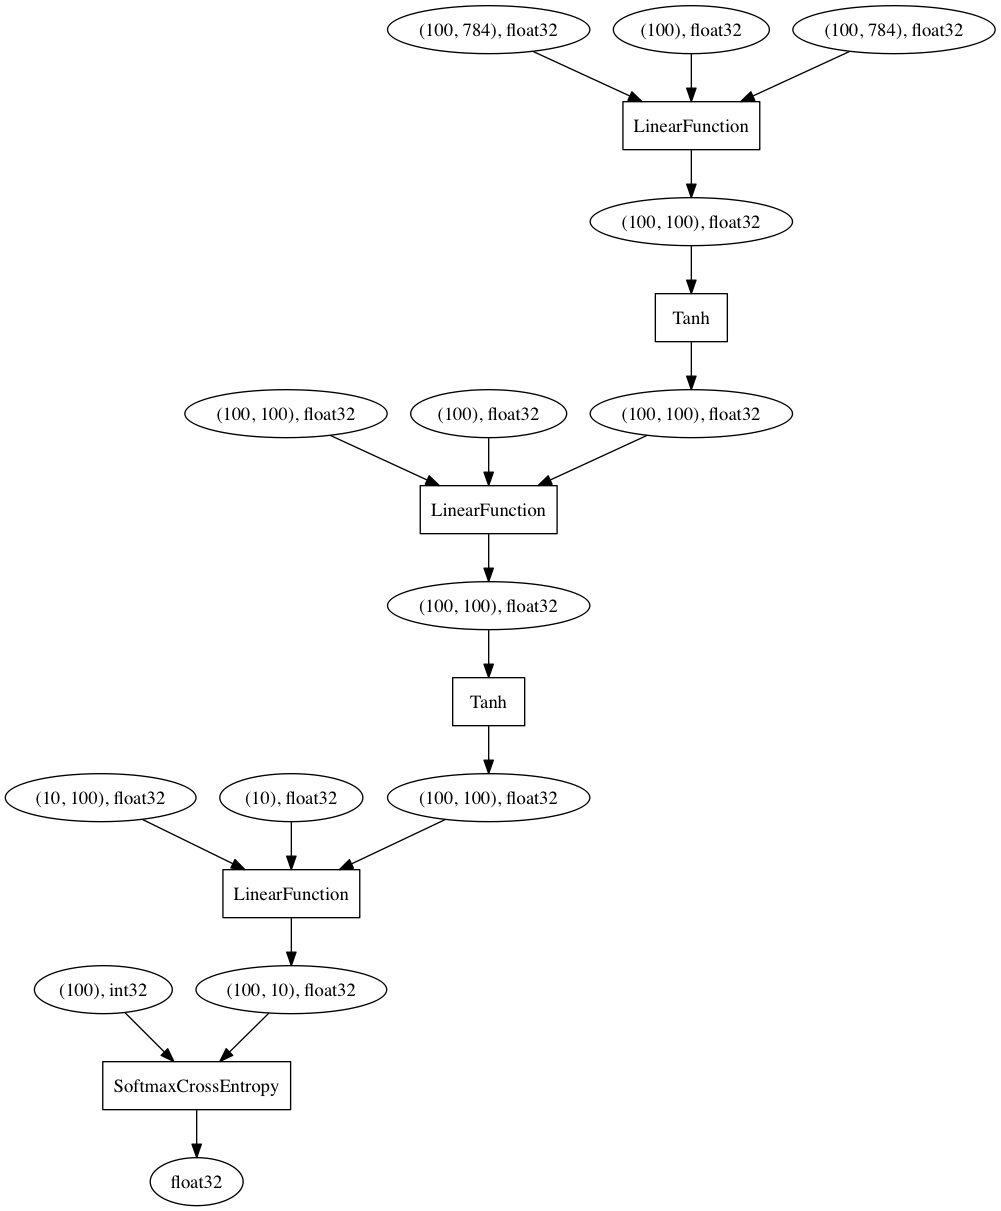

In [12]:
def display_graph():
    with open('graph.dot', 'w') as o:
        g = cg.build_computational_graph((model.loss, ))
        o.write(g.dump()) # write to .dot file

    graph = pydot.graph_from_dot_file('graph.dot') #load from .dot file
    graph.write_png('graph.png')
    
    img = Image('graph.png', width=600, height=600)
    display(img)
    
display_graph()

画像と予測ラベルのプロット

In [13]:
def plot_examples():
    plt.figure(figsize=(12,50))
    for i in range(45, 105):
        x = Variable(np.asarray(x_test[i:i+1])) #test data
        t = Variable(np.asarray(y_test[i:i+1])) #labels
        _ = model(x, t)
        prediction = model.y.data.argmax(axis=1)
        example = (x_test[i:i+1]*255).astype(np.int32).reshape(28, 28)
        plt.subplot(20, 5, i-44)
        plt.imshow(example, cmap='gray')
        plt.title("NO.{0} / Answer:{1}, Predict:{2}".format(i, t.data[0], prediction[0]))
        plt.axis("off")
    plt.tight_layout()

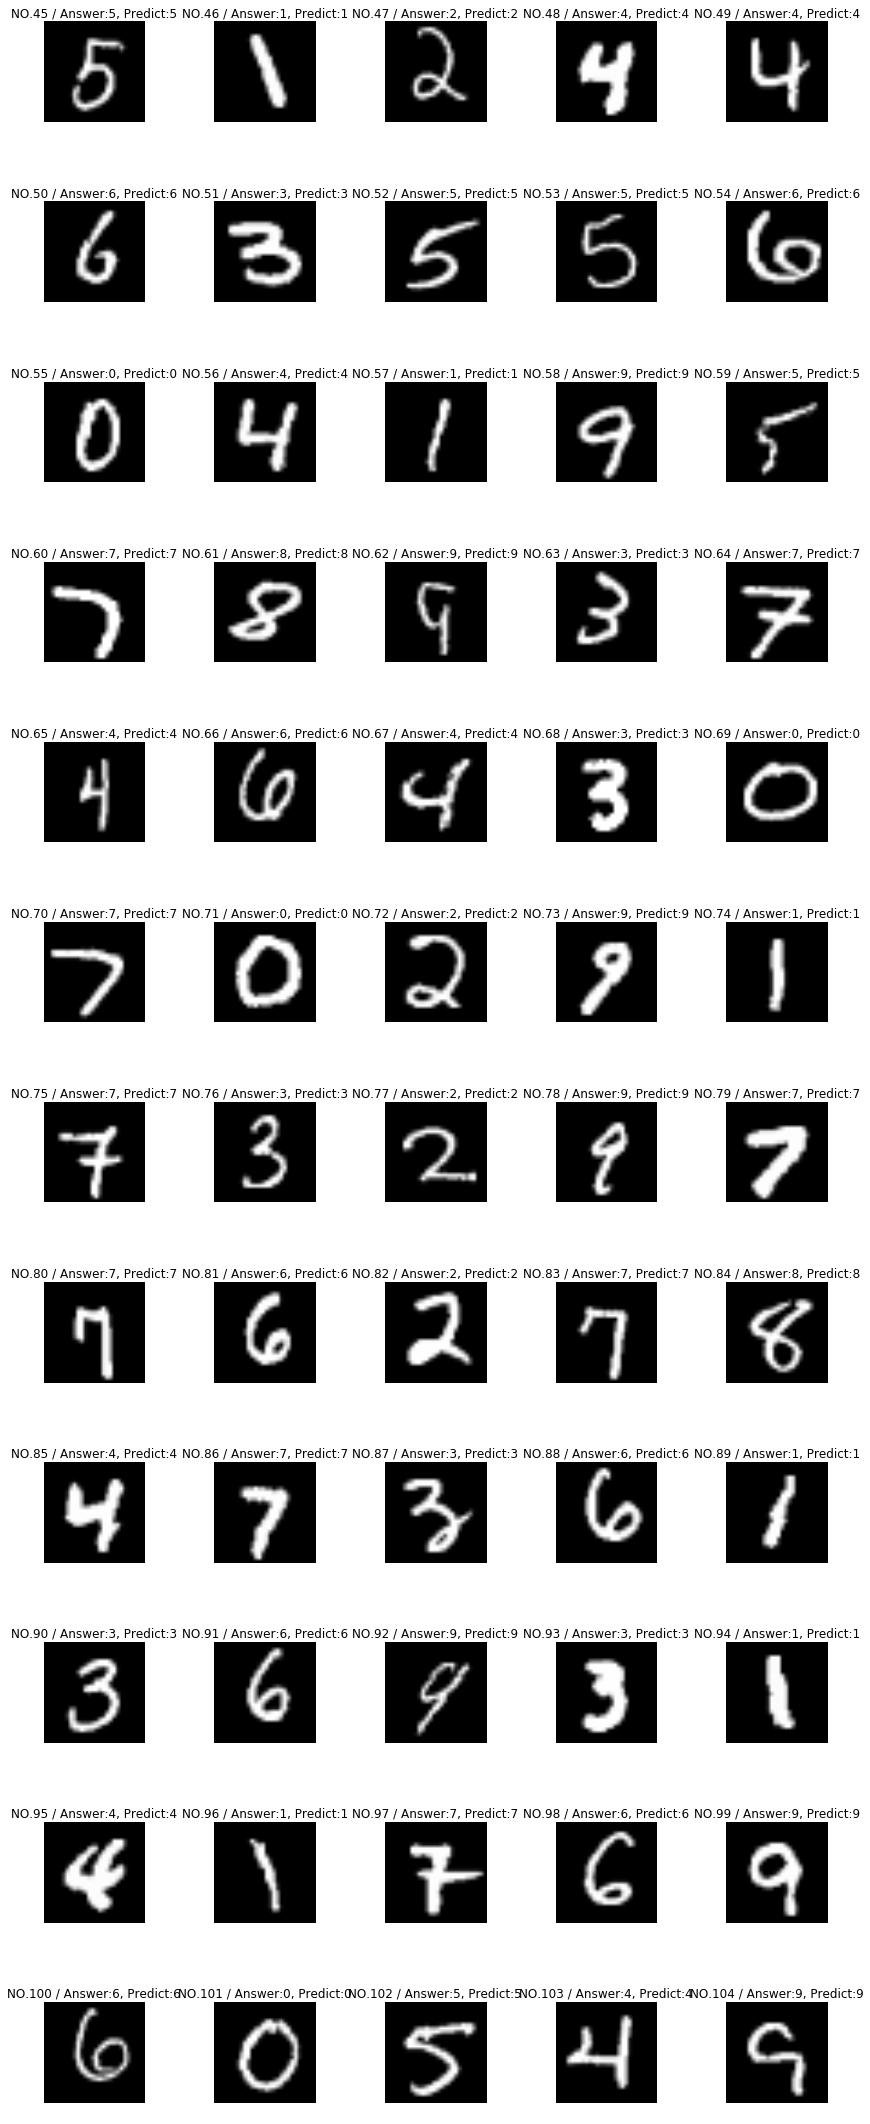

In [14]:
plot_examples()

In [ ]:
class Classifier(Chain):
     def __init__(self, predictor):
            super(Classifier, self).__init__(predictor=predictor)

    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.softmax_cross_entropy(y, t)
        accuracy = F.accuracy(y, t)
        report({'loss': loss, 'accuracy': accuracy}, self)         
        return loss